# Svensson (1994)



$$ r(t) = \beta_1 + \beta_2\frac{1-e^{-\lambda_1 t}}{\lambda_1 t} 
        + \beta_3 \left(\frac{1-e^{-\lambda_1 t}}{\lambda_1 t}-e^{-\lambda_1 t}\right)
        + \beta_4 \left(\frac{1-e^{-\lambda_2 t}}{\lambda_2 t}-e^{-\lambda_2 t}\right)$$

### Importing the data

In [230]:
from scipy.optimize import fmin
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from bizdays import Calendar
import os

path = r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\ETTJ"

df = pd.read_excel(os.path.join(path, "Titulos.xlsx"))
parameters = pd.read_excel(os.path.join(path, "Parametros.xlsx"))
selic = pd.read_excel(os.path.join(path, "SELIC.xlsx"))

#### Maturity and Coupon Calculation


In [231]:
### CDI treatments

selic.rename(columns={'Data': 'DATA_REFERENCIA'}, inplace=True)
selic.rename(columns={'CDI': 'EXPECTATIVA'}, inplace=True)
selic["CODIGO"]="SELIC"
selic["DATA_VENCIMENTO"]=cal.offset(selic["DATA_REFERENCIA"],1)
selic["PU"]=1000/((1+selic['EXPECTATIVA'])**(1/252))
selic = selic[["CODIGO",'DATA_REFERENCIA',"DATA_VENCIMENTO",'EXPECTATIVA',"PU"]]
df = pd.concat([df, selic], ignore_index=True)

In [232]:
cal = Calendar.load("ANBIMA")
parameters.set_index("Data referência", inplace=True)

### Maturity Calculation

#df = pd.concat([df, CDI], ignore_index=True)
df["Maturity"] = np.array(cal.bizdays(df["DATA_REFERENCIA"], df["DATA_VENCIMENTO"]))/252


### Coupon Calculation

df["Coupon"] = df["CODIGO"].apply(lambda x: 10 if x == "NTN-F" else 0)
df['DATA_VENCIMENTO'] = pd.to_datetime(df['DATA_VENCIMENTO'])


# Function to generate the number of coupon days between two dates
def calculate_coupon_days(reference_date, maturity_date):
    first_january = pd.Timestamp(reference_date).replace(month=1, day=1)
    first_july = pd.Timestamp(reference_date).replace(month=7, day=1)
    
    coupon_dates = [first_january, first_july]
    
    next_january = first_january + pd.DateOffset(years=1)
    next_july = first_july + pd.DateOffset(years=1)
    
    while next_january <= maturity_date:
        coupon_dates.append(next_january)
        coupon_dates.append(next_july)
        next_january = next_january + pd.DateOffset(years=1)
        next_july = next_july + pd.DateOffset(years=1)
    
    coupon_days = [cal.bizdays(reference_date, coupon_date) for coupon_date in coupon_dates if coupon_date >= reference_date and coupon_date <= maturity_date]
    return coupon_days

# Função para calcular os cupons
def calculate_coupons(row):
    if row["CODIGO"] != "NTN-F":
        return np.zeros(0, dtype=int)  # Retorna um array vazio se não for "NTN-F"
    else:
        return np.array(calculate_coupon_days(row['DATA_REFERENCIA'], row['DATA_VENCIMENTO']), dtype=int)

# Apply a função para calcular cupons
df["Coupons_days"] = df.apply(calculate_coupons, axis=1)

df["Duration"]=1000*((1+0.1)**(1/2)-1)/((1+df["EXPECTATIVA"]/100)**(df["Coupons_days"]/252))*(df["Coupons_days"]/252)
payment=1000/((1+df["EXPECTATIVA"]/100)**df["Maturity"])*df["Maturity"]

# Função para somar os elementos de uma lista
def sum_duration(row):
    return np.sum(row)

# Aplicar a função a cada linha da coluna "Duration"
df["Duration"] = (df["Duration"].apply(sum_duration)+payment)/df["PU"]

df.set_index("DATA_REFERENCIA", inplace=True)

C:\Users\Alysson\AppData\Local\Temp\ipykernel_21244\412710204.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df['DATA_VENCIMENTO'] = pd.to_datetime(df['DATA_VENCIMENTO'])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_21244\412710204.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df['DATA_VENCIMENTO'] = pd.to_datetime(df['DATA_VENCIMENTO'])
C:\Users\Alysson\AppData\Local\Temp\ipykernel_21244\412710204.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-compa

In [233]:
df

,CODIGO,DATA_VENCIMENTO,EXPECTATIVA,PU,Maturity,Coupon,Coupons_days,Duration
DATA_REFERENCIA,,,,,,,,
2023-07-03,LTN,2023-10-01,13.2025,968.996662,0.250000,0,[],0.250123
2023-07-03,LTN,2024-01-01,12.7468,942.225059,0.492063,0,[],0.492298
2023-07-03,LTN,2024-04-01,12.1642,918.761537,0.738095,0,[],0.738095
2023-07-03,LTN,2024-07-01,11.5298,897.786879,0.988095,0,[],0.988095
2023-07-03,LTN,2024-10-01,11.0232,877.471104,1.250000,0,[],1.250000
...,...,...,...,...,...,...,...,...
2023-08-21,SELIC,2023-08-22,13.1500,989.540346,0.003968,0,[],0.004008
2023-08-22,SELIC,2023-08-23,13.1500,989.540346,0.003968,0,[],0.004008
2023-08-23,SELIC,2023-08-24,13.1500,989.540346,0.003968,0,[],0.004008



### Generating individuals

In [242]:
N =1200             ### Number of individuals 
p = int(2/3*N)      ### Proportion of individuals generated by method 1
var = 0.25           ### variance normal distribution

### 1 - Initial Values of the results of the estimation of the previous day

ref_date_str = "2023-07-26"
ref_date = datetime.strptime(ref_date_str, "%Y-%m-%d")
previous_date = cal.offset(ref_date_str,-1)
previous_parameters = parameters.loc[str(previous_date)][1:]
beta_star_1 = np.array([previous_parameters.replace(previous_parameters[1],previous_parameters[0])])
e_previous = beta_star_1.T*np.random.normal(0, var, size=(6, p))
beta_previous = beta_star_1.T + e_previous

### 2 - Approximation that takes into account the observed yield to maturity (ytm)

data_estimada = df.loc[ref_date_str]
data_estimada=data_estimada.sort_values("Maturity")
b1 = data_estimada["EXPECTATIVA"][0]/100
b2 = data_estimada["EXPECTATIVA"][-1]/100 - data_estimada["EXPECTATIVA"][0]/100
b3 = 0
b4 = 0
lbda1 = previous_parameters[4]
lbda2 = previous_parameters[5]
#lbda1 = (data_estimada["Maturity"][-1]-data_estimada["Maturity"][0])/2
#lbda2 = lbda1
beta_star_2 = np.array([b1, b2, b3 , b4, lbda1, lbda2])[:, np.newaxis]
e_approx = beta_star_2*np.random.normal(0, var, size=(6, N-p))
beta_approx = beta_star_2 + e_approx ## ajustar colunas

### Adding constraints to the parameters

def update (betas,beta_star):
    updated_value = []
    for index, parameter in enumerate(betas):
        if parameter[0]<0:
            betas[index][0] = beta_star[0]+ beta_star[0]*np.random.normal(0, var)
            updated_value.append(betas[index][0]<0)
        if (parameter[0]+parameter[1])<0:
            betas[index][1] = beta_star[1]+ beta_star[1]*np.random.normal(0, var)
            updated_value.append((betas[index][0]+betas[index][1])<0)
        if parameter[4]<0:
            betas[index][4] = beta_star[4]+ beta_star[4]*np.random.normal(0, var)
            updated_value.append(betas[index][4]<0)
        if parameter[5]<0:
            betas[index][5] = beta_star[5]+ beta_star[5]*np.random.normal(0, var)
            updated_value.append(betas[index][5]<0)
    if sum(updated_value) != 0:
        update(betas,beta_star)
    return(beta_previous.T)

update(beta_previous.T,beta_star_1.T)
update(beta_approx,beta_star_2)

individuals = np.concatenate((beta_previous.T, beta_approx.T), axis=0)

### Selection

In [245]:
df = df.loc[ref_date_str]

alpha = 6
var = 0.25
pi = 0.35
### 40% of the individuals survive
s = int(0.4 * N)
mty = df['Maturity']
cp_days = df["Coupons_days"]
price = df['PU']
duration = df["Duration"]

def myval(c):
    nss = (c[0]) + (c[1] * ((1 - np.exp(-mty * c[4])) / (mty * c[4]))) + (c[2] * ((((1 - np.exp(-mty * c[4])) / (mty * c[4]))) - (np.exp(-mty * c[4])))) + (c[3] * ((((1 - np.exp(-mty * c[5])) / (mty * c[5]))) - (np.exp(-mty * c[5]))))    
    df["Calculated_Coupon"] = 1000 * ((1 + 0.1) ** (1 / 2) - 1) / (1 + nss) ** (cp_days/ 252)
    df["Calculated_Coupon"] = df["Calculated_Coupon"].apply(sum_duration)
    Calculated_price = 1000 / (1 + nss) ** mty + df["Calculated_Coupon"]
    df["Residual"] = ((price - Calculated_price) ** 2) * (1 / duration ** 0.5)
    
    val = np.sum(df['Residual'])
    return val

for interation in range(10):

    values = []
    
    for row in individuals:    
        val = myval(row)
        values.append((round(val,1), row))
        
    sol = pd.DataFrame(values, columns=['SC', "Parameters"])

    selection = sol.sort_values('SC')[0:s]
    new_individuals = []
    
    if interation > 1:
        var = var*1.02
        
    ### Cross-Over
    
    selected_rows = selection.iloc[(np.random.beta(1, alpha, 1200) * s)]
    selected_rows.reset_index(drop=True, inplace=True)
    theta_r = selected_rows["Parameters"]
    theta_s = selected_rows["Parameters"]
         
    next_gen = psi * theta_r + (1 - psi) * theta_s
       
        
    ### Mutation
    e = np.random.choice([0, 1], size=(6, 1200), p=[1 - pi, pi])*np.random.normal(0, var, size=(6, 1200))
    next_gen_list = next_gen.tolist()
    next_gen_array = np.array(next_gen_list)        
        #new_ind = (np.array(next_gen)+np.array(next_gen)*np.array(e_mutation)).flatten() 
        #conditions = [new_ind[0]>0, (new_ind[0]+new_ind[1])>0 , new_ind[4]>0, new_ind[5]>0]
        #if all(conditions):         
        #new_individuals.append(new_ind.tolist())
    new_individuals = next_gen_array * e.T+next_gen_array
         
    individuals = new_individuals
    

        
selection.head()

,SC,Parameters
1184,1602.7,"[0.11165095420222679, 0.055414534324408016, 0...."
1141,1603.3,"[0.11165095420222679, 0.05003497909179945, 0.0..."
1092,1603.3,"[0.11165095420222679, 0.05003497909179945, 0.0..."
509,1603.6,"[0.11165095420222679, 0.039019804871086694, 0...."
911,1603.6,"[0.11165095420222679, 0.039019804871086694, 0...."


In [246]:
dia26 = selection.iloc[0]["Parameters"]
dia26_anbima = parameters.iloc[-2,1:].values
print(dia26)
print(dia26_anbima)

[ 0.11165095  0.05541453  0.02885044 -0.11269342  1.90792851  1.48879329]
[0.114358254774121 0.018715794279205 0.0679754297455865
 -0.0961284649369684 2.70022735771407 1.22958147196742]


Text(0.5, 1.0, '2023-07-26 00:00:00')

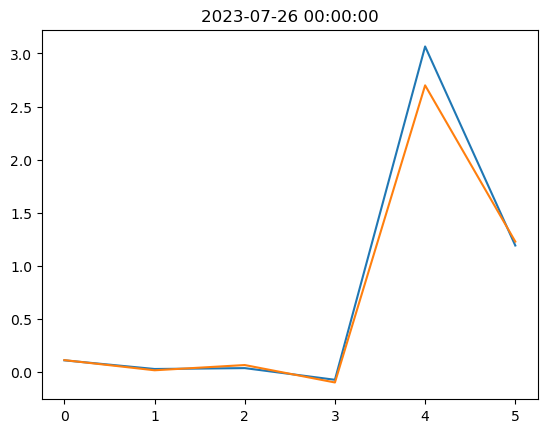

In [247]:
rounded_series = selection["Parameters"].apply(lambda lst: [round(x, 1) for x in lst])
rounded_series[0:99]
plt.plot(dia27)
plt.plot(dia27_anbima)
plt.title(f'{ref_date}')